# Pipeline for High-z Radio Galaxies 27: SHAP values for meta models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the meta-learners used for predictions.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap

In [2]:
mpl.rcdefaults()

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

In [4]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()

In [5]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

---

In [6]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False

### Load data

In [7]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [8]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS' 

In [9]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [10]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [11]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [12]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6729647 entries, 0 to 6729646
Data columns (total 91 columns):
 #   Column        Dtype  
---  ------        -----  
 0   RA_ICRS       float32
 1   DE_ICRS       float32
 2   Name          object 
 3   TYPE          object 
 4   Z             float32
 5   zsp           float32
 6   spCl          object 
 7   band_num      int64  
 8   radio_detect  bool   
 9   is_str        int64  
 10  is_AGN        int64  
 11  is_SDSS_gal   int64  
 12  is_gal        int64  
 13  W1mproPM      float32
 14  W2mproPM      float32
 15  gmag          float32
 16  rmag          float32
 17  imag          float32
 18  zmag          float32
 19  ymag          float32
 20  Jmag          float32
 21  Hmag          float32
 22  Kmag          float32
 23  W3mag         float32
 24  W4mag         float32
 25  g_r           float32
 26  g_i           float32
 27  g_z           float32
 28  g_y           float32
 29  g_J           float32
 30  g_H           floa

Create features with class and combined redshift.

In [13]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [14]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

In [15]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [16]:
seed                                = 42

### Load models

In [17]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model('models/classification_star_no_star_jun_30_2022')  # star/no-star model
    AGN_gal_clf         = pyc.load_model('models/classification_AGN_galaxy_ago_03_2022')  # classification_AGN_galaxy_may_15_2022
    cal_AGN_gal_clf     = load('models/cal_classification_AGN_galaxy_ago_03_2022.joblib')  # calibrated model
    radio_det_clf       = pyc.load_model('models/classification_radio_detect_ago_02_2022')  # without predicted AGN
    cal_radio_det_clf   = load('models/cal_classification_radio_detect_ago_02_2022.joblib')  # calibrated model
    redshift_reg        = pyr.load_model('models/regression_z_ago_04_2022')  # to use on full sample regression_z_may_17_2022
    if use_second_z_model:
        # redshift_reg_2  = pyr.load_model('models/regression_z_may_31_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_2  = pyr.load_model('models/regression_z_may_31_4_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_2  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 used with SMOGN
        redshift_reg_2  = pyr.load_model('models/regression_z_jul_19_2022')  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [18]:
if use_zeroth_model:
    threshold_star       = 0.37441  # 0.5, 0.15688 from ROC AUC in train+test, 0.37441 from PR curve
threshold_AGN            = 0.48620  # 0.5, 0.3094 from ROC AUC in train+test, 0.31117 from PR curve
threshold_radio          = 0.49589  # 0.5, 4.99972232e-01, 3.45872868e-01 without including new AGN from ROC AUC in train+test and PR curve

threshold_cal_AGN        = 0.45148  # From calibrated model (probabilities) 0.45148
threshold_cal_radio      = 0.25453  # From calibrated model (probabilities) 0.25453

#### Select relevant sources

In this case, high-redshift sources

In [20]:
redshift_lim       = 3.6
filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= redshift_lim)

In [21]:
full_catalog_df    = full_catalog_df.loc[filter_selection]

Predictions

In [22]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=threshold_star, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [23]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [24]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [25]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=6)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [26]:
redshift_lim    = 3.6
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [27]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on each meta learner.

In [28]:
run_shap_AGN_meta    = True
run_shap_radio_meta  = True
run_shap_z_meta      = True
run_shap_high_z_meta = True

In [29]:
selected_color = plt.get_cmap('cmr.guppy')  # cmr.pride, cet_CET_R3 cmr.wildfire cmr.guppy

#### SHAP - AGN/galaxy model

In [30]:
if run_shap_AGN_meta:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [31]:
if run_shap_AGN_meta:
    sample_size_AGN  = 1000
    sub_size_AGN     = np.nanmin([sample_size_AGN, np.sum(filter_selection)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 381


In [32]:
if run_shap_AGN_meta:
    estimators_list_AGN = get_base_estimators_names(AGN_gal_clf)

In [34]:
if run_shap_AGN_meta:
    reduced_data_AGN = full_catalog_df.loc[:, get_final_column_names(AGN_gal_clf, full_catalog_df)].sample(n=sub_size_AGN, random_state=seed).copy()
    reduced_idx_AGN  = reduced_data_AGN.index
    reduced_cols_AGN = reduced_data_AGN.columns
    reduced_cols_AGN = reduced_data_AGN.columns.insert(0, estimators_list_AGN[0])
    if len(estimators_list_AGN) > 1:
        for est_name in estimators_list_AGN[1::]:
            reduced_cols_AGN = reduced_cols_AGN.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [35]:
if run_shap_AGN_meta:
    print('Running data pre-processing:\n')
    if isinstance(AGN_gal_clf, sklearn.pipeline.Pipeline):
        prep_steps = AGN_gal_clf.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_AGN = method.transform(reduced_data_AGN)
    reduced_data_AGN_df = pd.DataFrame(reduced_data_AGN, columns=reduced_cols_AGN, index=reduced_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [36]:
if run_shap_AGN_meta:
    explainer_AGN_meta = fasttreeshap.TreeExplainer(AGN_gal_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=reduced_data_AGN_df, feature_perturbation='interventional',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [37]:
if run_shap_AGN_meta:
    print('Working with meta-model')
    shap_values_AGN_meta = explainer_AGN_meta(reduced_data_AGN_df)

Working with meta-model


In [38]:
if run_shap_AGN_meta:
    explainer_AGN_meta.expected_value

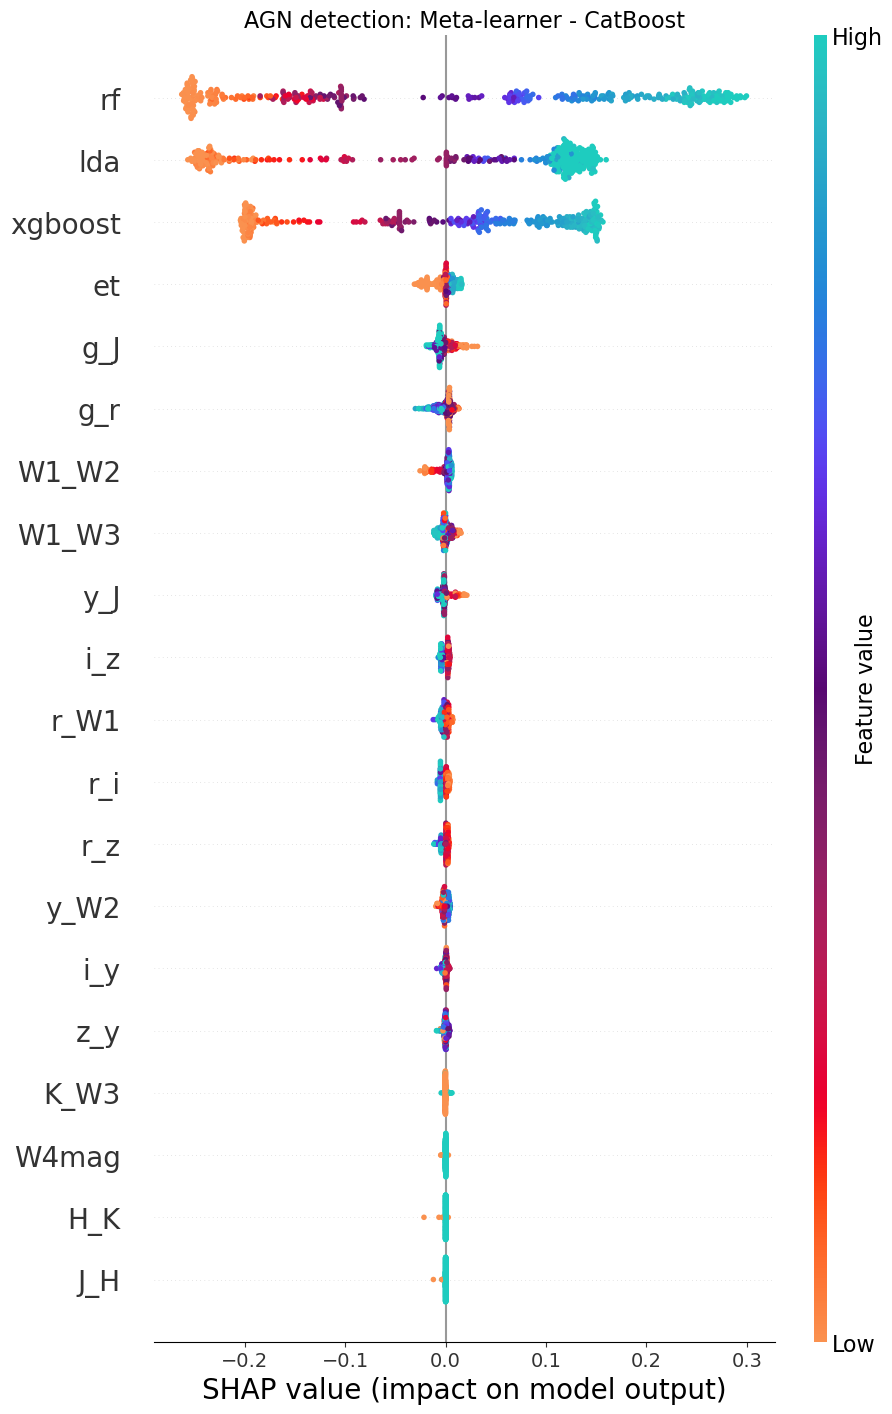

In [39]:
if run_shap_AGN_meta:
    shap.plots.beeswarm(copy.deepcopy(shap_values_AGN_meta), log_scale=False, show=False, color_bar=False,
                        color=selected_color, max_display=len(shap_values_AGN_meta.feature_names), alpha=1.0)
    _, h = plt.gcf().get_size_inches()

    m = cm.ScalarMappable(cmap=selected_color)
    cb = plt.colorbar(m, ticks=[0, 1], aspect=100)
    cb.set_ticklabels([shap.plots._labels.labels['FEATURE_VALUE_LOW'], shap.plots._labels.labels['FEATURE_VALUE_HIGH']])
    cb.set_label(shap.plots._labels.labels["FEATURE_VALUE"], size=16, labelpad=-20)
    cb.ax.tick_params(labelsize=16, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

    plt.gca().tick_params('x', labelsize=14)
    plt.gca().xaxis.get_offset_text().set_fontsize(14)
    plt.gca().xaxis.get_offset_text().set_position((0,1))
    plt.gca().tick_params('y', labelsize=20)
    plt.gca().xaxis.label.set_size(20)

    plt.title(f'AGN detection: Meta-learner - {model_name_AGN}', fontsize=16)

    plt.gcf().set_size_inches(h, h*3/2)
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_AGN_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

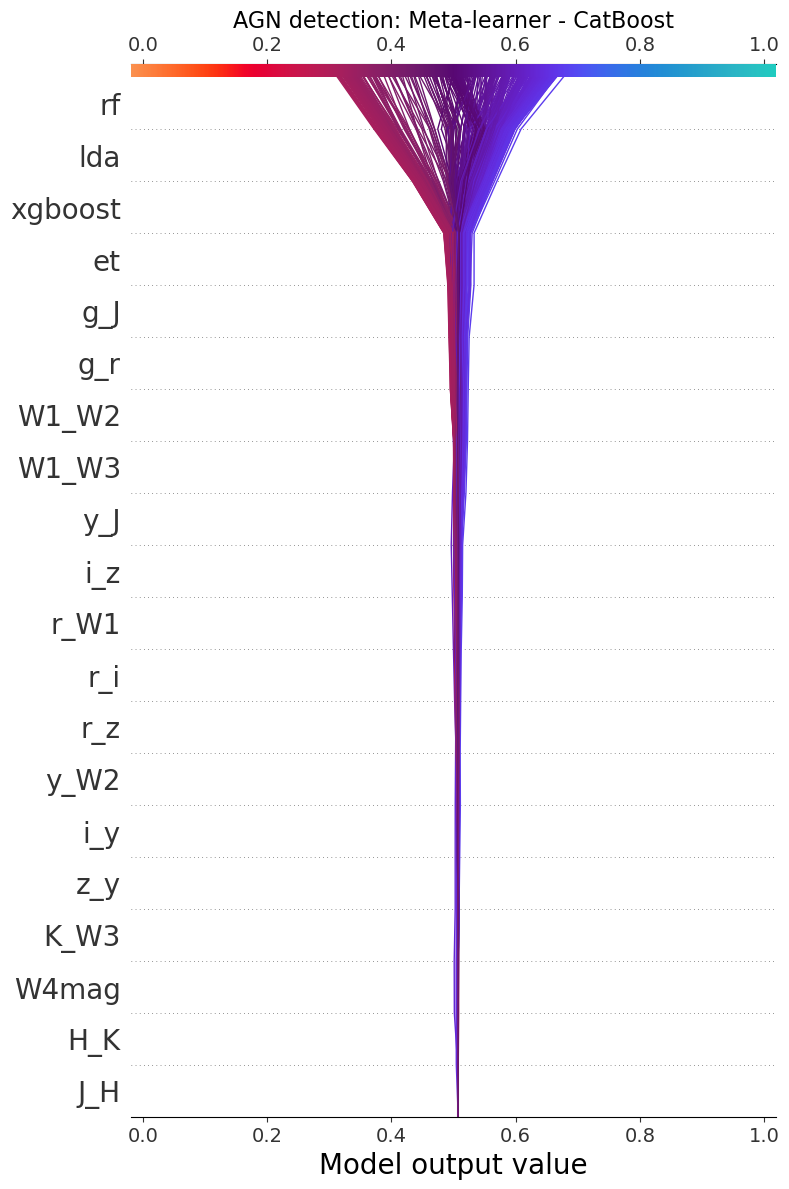

In [40]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.5 - 2.2e-5, 0.5 + 2.1e-5)
if run_shap_AGN_meta:
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    shap.plots.decision(base_value=explainer_AGN_meta.expected_value,
                        shap_values=shap_values_AGN_meta.values,
                        feature_names=reduced_cols_AGN.to_list(),
                        link='logit', plot_color=selected_color,
                        highlight=None, auto_size_plot=False,
                        show=False, xlim=None,
                        feature_display_range=slice(-1, -(len(shap_values_AGN_meta.feature_names) +1), -1))
    
    ax1.tick_params('x', labelsize=14)
    ax1.xaxis.get_offset_text().set_fontsize(14)
    #ax1.xaxis.get_offset_text().set_position((0,1))
    ax1.tick_params('y', labelsize=20)
    # plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax1.xaxis.label.set_size(20)
    
    plt.title(f'AGN detection: Meta-learner - {model_name_AGN}', fontsize=16)
    
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_decision_AGN_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

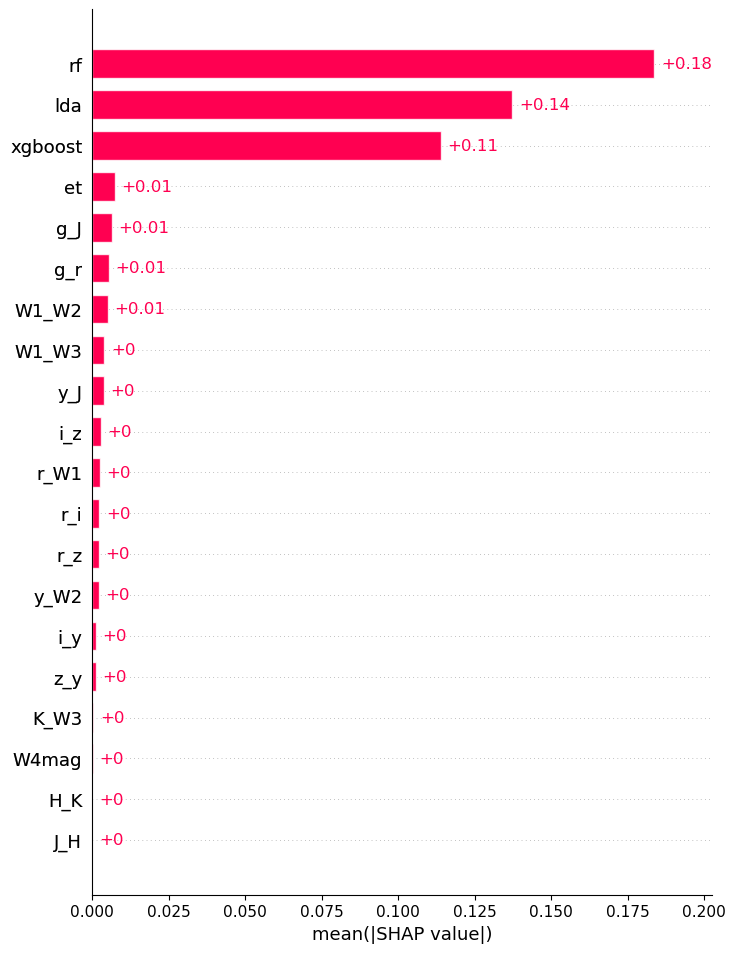

In [41]:
if run_shap_AGN_meta:
    shp_copy_AGN = shap.Explanation(values=shap_values_AGN_meta.values,\
                                    base_values=shap_values_AGN_meta.base_values,\
                                    data=shap_values_AGN_meta.data,\
                                    feature_names=shap_values_AGN_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_AGN, max_display=len(shp_copy_AGN.feature_names), show=False)
    plt.show()

In [42]:
if run_shap_AGN_meta:
    # The model's raw prediction for the first observation.
    print(AGN_gal_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_AGN_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_AGN_meta.expected_value + shap_values_AGN_meta.values[0].sum()).round(5))

1
0.51833


---

#### SHAP - Radio detection model

In [43]:
if run_shap_radio_meta:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [44]:
if run_shap_radio_meta:
    sample_size_radio = 1000
    if use_zeroth_model:
        filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
    elif not use_zeroth_model:
        filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    filter_pred_AGN   = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    sample_size_radio = np.nanmin([sample_size_radio, np.sum(filter_selection)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 381


In [45]:
if run_shap_radio_meta:
    estimators_list_radio = get_base_estimators_names(radio_det_clf)

In [47]:
if run_shap_radio_meta:
    reduced_data_radio = full_catalog_df.loc[:,\
                                             get_final_column_names(radio_det_clf, full_catalog_df)].sample(n=sample_size_radio, random_state=seed).copy()
    reduced_idx_radio  = reduced_data_radio.index
    reduced_cols_radio = reduced_data_radio.columns
    reduced_cols_radio = reduced_data_radio.columns.insert(0, estimators_list_radio[0])
    if len(estimators_list_radio) > 1:
        for est_name in estimators_list_radio[1::]:
            reduced_cols_radio = reduced_cols_radio.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [48]:
if run_shap_radio_meta:
    print('Running data pre-processing:\n')
    if isinstance(radio_det_clf, sklearn.pipeline.Pipeline):
        prep_steps = radio_det_clf.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_radio = method.transform(reduced_data_radio)
    reduced_data_radio_df = pd.DataFrame(reduced_data_radio, columns=reduced_cols_radio, index=reduced_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [49]:
if run_shap_radio_meta:
    explainer_radio_meta = fasttreeshap.TreeExplainer(radio_det_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=reduced_data_radio_df, feature_perturbation='interventional',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [50]:
if run_shap_radio_meta:
    print('Working with meta-model')
    shap_values_radio_meta = explainer_radio_meta(reduced_data_radio_df)

Working with meta-model


In [51]:
if run_shap_radio_meta:
    explainer_radio_meta.expected_value

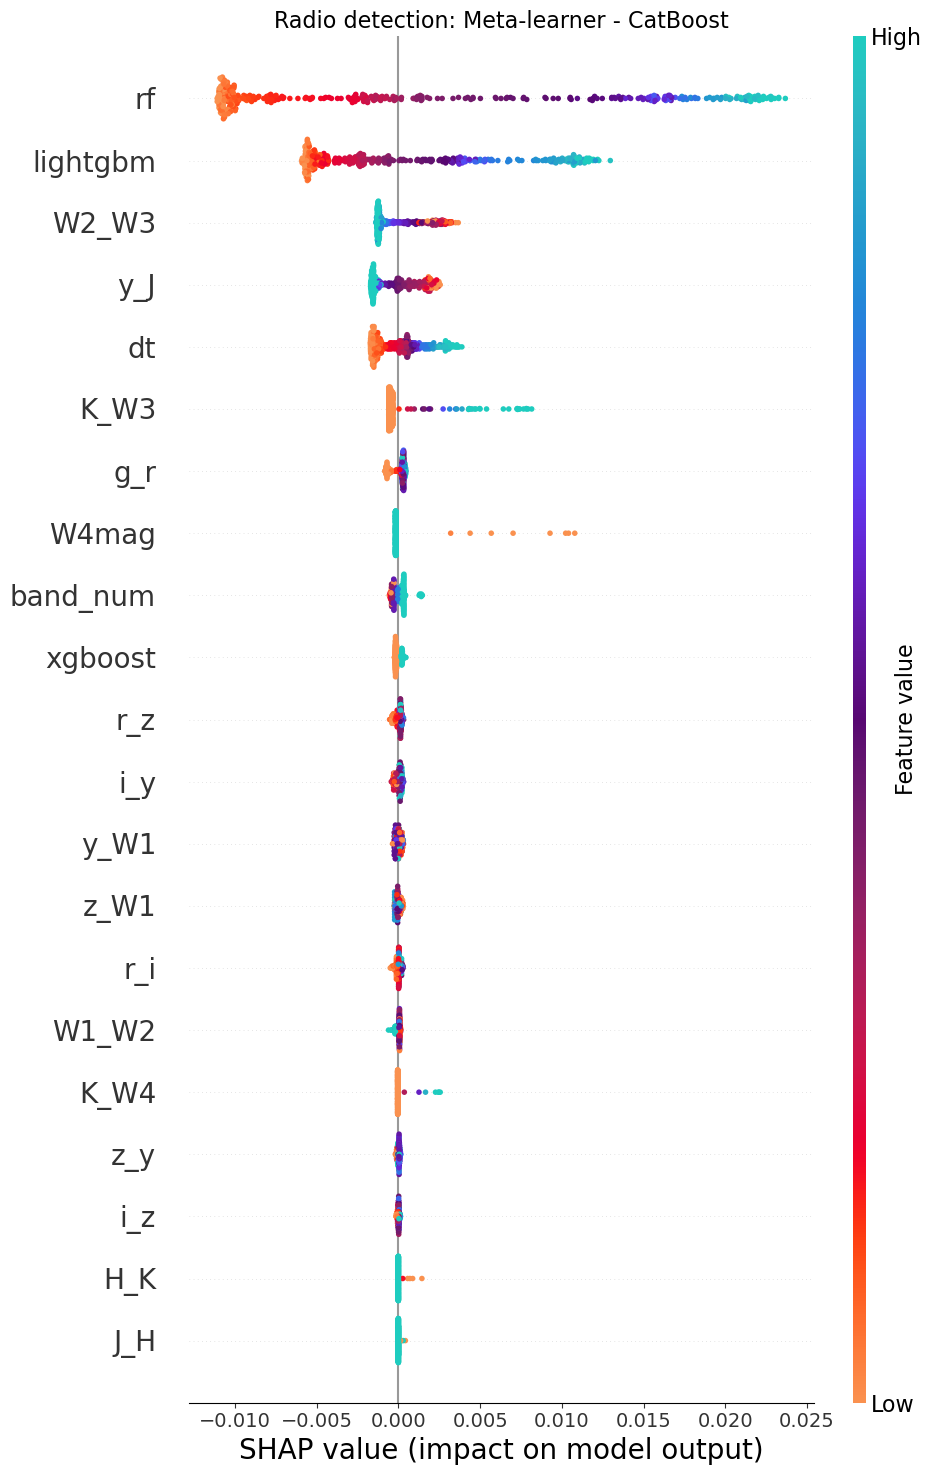

In [52]:
if run_shap_radio_meta:
    shap.plots.beeswarm(copy.deepcopy(shap_values_radio_meta), log_scale=False, show=False, color_bar=False,
                        color=selected_color, max_display=len(shap_values_radio_meta.feature_names), alpha=1.0)
    _, h = plt.gcf().get_size_inches()

    m = cm.ScalarMappable(cmap=selected_color)
    cb = plt.colorbar(m, ticks=[0, 1], aspect=100)
    cb.set_ticklabels([shap.plots._labels.labels['FEATURE_VALUE_LOW'], shap.plots._labels.labels['FEATURE_VALUE_HIGH']])
    cb.set_label(shap.plots._labels.labels["FEATURE_VALUE"], size=16, labelpad=-20)
    cb.ax.tick_params(labelsize=16, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

    plt.gca().tick_params('x', labelsize=14)
    plt.gca().xaxis.get_offset_text().set_fontsize(14)
    plt.gca().xaxis.get_offset_text().set_position((0,1))
    plt.gca().tick_params('y', labelsize=20)
    plt.gca().xaxis.label.set_size(20)

    plt.title(f'Radio detection: Meta-learner - {model_name_radio}', fontsize=16)

    plt.gcf().set_size_inches(h, h*3/2)
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_radio_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

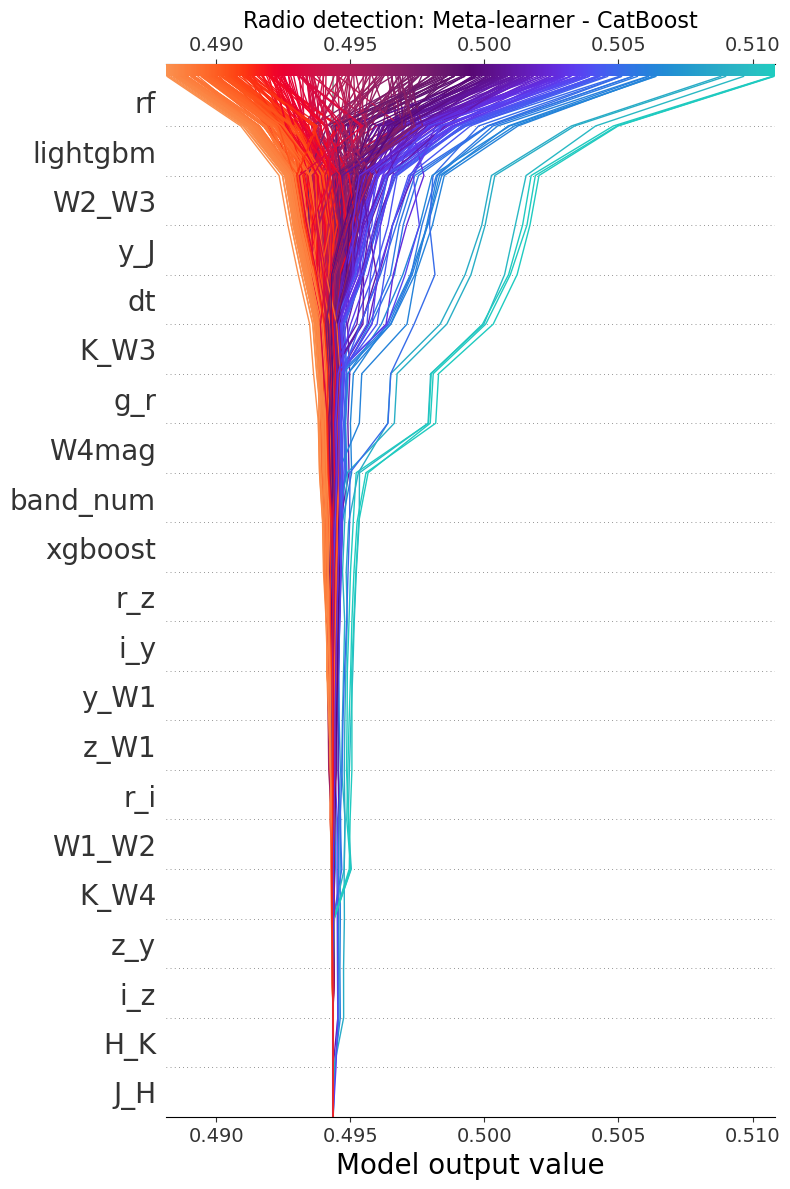

In [53]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_radio_meta:
    xlims_plt       = (full_catalog_df.loc[reduced_idx_radio, 'Score_radio'].min() * 0.9999,\
                       full_catalog_df.loc[reduced_idx_radio, 'Score_radio'].max() * 1.0001)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    shap.plots.decision(base_value=explainer_radio_meta.expected_value,
                        shap_values=shap_values_radio_meta.values,
                        feature_names=reduced_cols_radio.to_list(),
                        link='logit', plot_color=selected_color,
                        highlight=None, auto_size_plot=False,
                        show=False, xlim=xlims_plt,
                        feature_display_range=slice(-1, -(len(shap_values_radio_meta.feature_names) +1), -1))
    
    ax1.tick_params('x', labelsize=14)
    ax1.xaxis.get_offset_text().set_fontsize(14)
    #ax1.xaxis.get_offset_text().set_position((0,1))
    ax1.tick_params('y', labelsize=20)
    # plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax1.xaxis.label.set_size(20)
    
    plt.title(f'Radio detection: Meta-learner - {model_name_radio}', fontsize=16)
    
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_decision_radio_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

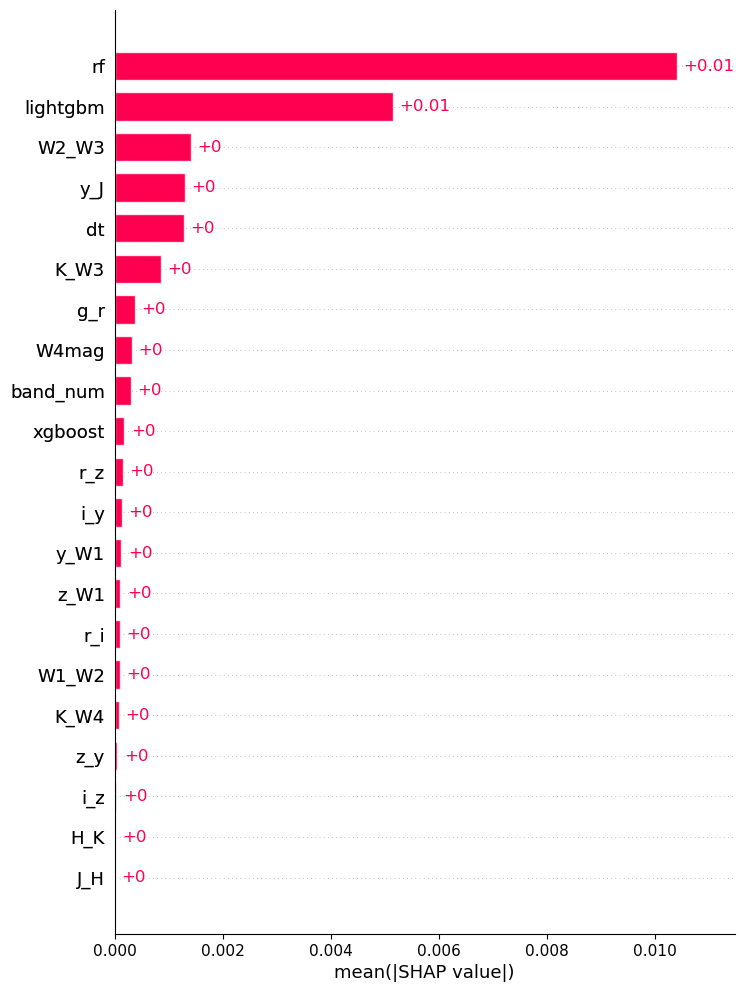

In [54]:
if run_shap_radio_meta:
    shp_copy_radio = shap.Explanation(values=shap_values_radio_meta.values,\
                                    base_values=shap_values_radio_meta.base_values,\
                                    data=shap_values_radio_meta.data,\
                                    feature_names=shap_values_radio_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_radio, max_display=len(shp_copy_radio.feature_names), show=False)
    plt.show()

In [55]:
if run_shap_radio_meta:
    # The model's raw prediction for the first observation.
    print(radio_det_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_radio_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_radio_meta.expected_value + shap_values_radio_meta.values[0].sum()).round(5))

0
-0.01101


---

#### SHAP - First redshift prediction model

In [56]:
if run_shap_z_meta:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [57]:
if run_shap_z_meta:
    sample_size_z    = 1000
    filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z    = np.nanmin([sample_size_z, np.sum(filter_selection)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 381


In [58]:
if run_shap_z_meta:
    estimators_list_z = get_base_estimators_names(redshift_reg)

In [60]:
if run_shap_z_meta:
    reduced_data_z = full_catalog_df.loc[:,\
                                         get_final_column_names(redshift_reg, full_catalog_df)].sample(n=sample_size_z, random_state=seed).copy()
    reduced_idx_z  = reduced_data_z.index
    reduced_cols_z = reduced_data_z.columns
    reduced_cols_z = reduced_data_z.columns.insert(0, estimators_list_z[0])
    if len(estimators_list_z) > 1:
        for est_name in estimators_list_z[1::]:
            reduced_cols_z = reduced_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [61]:
if run_shap_z_meta:
    print('Running data pre-processing:\n')
    if isinstance(redshift_reg, sklearn.pipeline.Pipeline):
        prep_steps = redshift_reg.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_z = method.transform(reduced_data_z)
    reduced_data_z_df = pd.DataFrame(reduced_data_z, columns=reduced_cols_z, index=reduced_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [62]:
if run_shap_z_meta:
    explainer_z_meta = fasttreeshap.TreeExplainer(redshift_reg.named_steps['trained_model'].final_estimator_,\
                                                  data=reduced_data_z_df, feature_perturbation='interventional',\
                                                  model_output='raw', feature_dependence='independent',\
                                                  algorithm='auto', n_jobs=12)

In [63]:
if run_shap_z_meta:
    print('Working with meta-model')
    shap_values_z_meta = explainer_z_meta(reduced_data_z_df)

Working with meta-model


In [64]:
if run_shap_z_meta:
    explainer_z_meta.expected_value

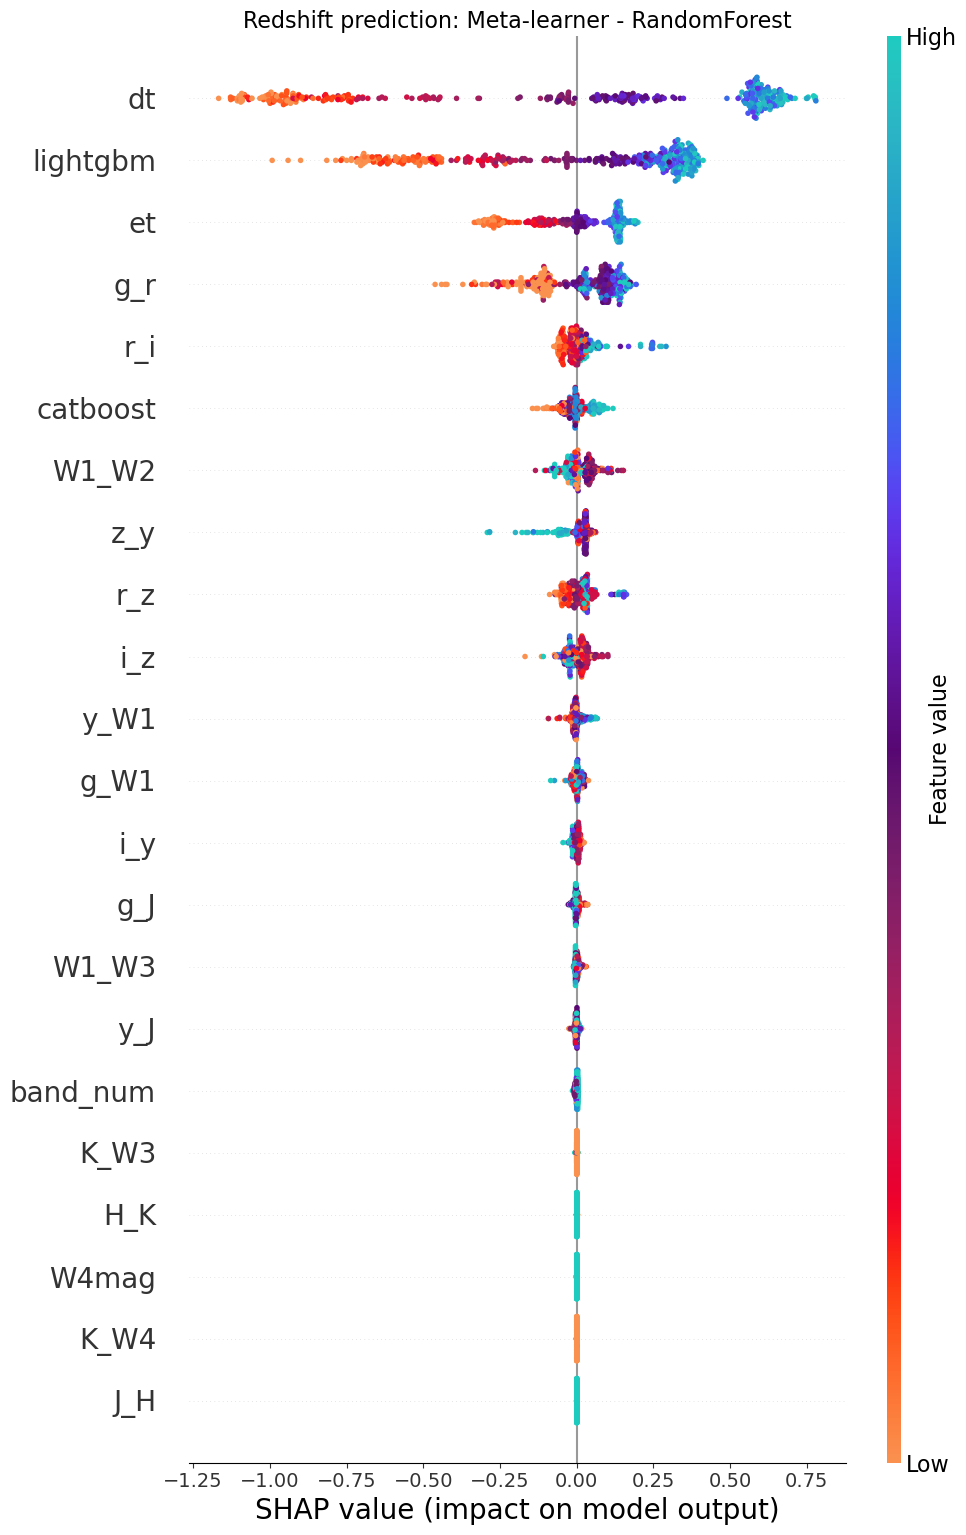

In [65]:
if run_shap_z_meta:
    shap.plots.beeswarm(copy.deepcopy(shap_values_z_meta), log_scale=False, show=False, color_bar=False,
                        color=selected_color, max_display=len(shap_values_z_meta.feature_names), alpha=1.0)
    _, h = plt.gcf().get_size_inches()

    m = cm.ScalarMappable(cmap=selected_color)
    cb = plt.colorbar(m, ticks=[0, 1], aspect=100)
    cb.set_ticklabels([shap.plots._labels.labels['FEATURE_VALUE_LOW'], shap.plots._labels.labels['FEATURE_VALUE_HIGH']])
    cb.set_label(shap.plots._labels.labels["FEATURE_VALUE"], size=16, labelpad=-20)
    cb.ax.tick_params(labelsize=16, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

    plt.gca().tick_params('x', labelsize=14)
    plt.gca().xaxis.get_offset_text().set_fontsize(14)
    plt.gca().xaxis.get_offset_text().set_position((0,1))
    plt.gca().tick_params('y', labelsize=20)
    plt.gca().xaxis.label.set_size(20)

    plt.title(f'Redshift prediction: Meta-learner - {model_name_z}', fontsize=16)

    plt.gcf().set_size_inches(h, h*3/2)
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_z_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

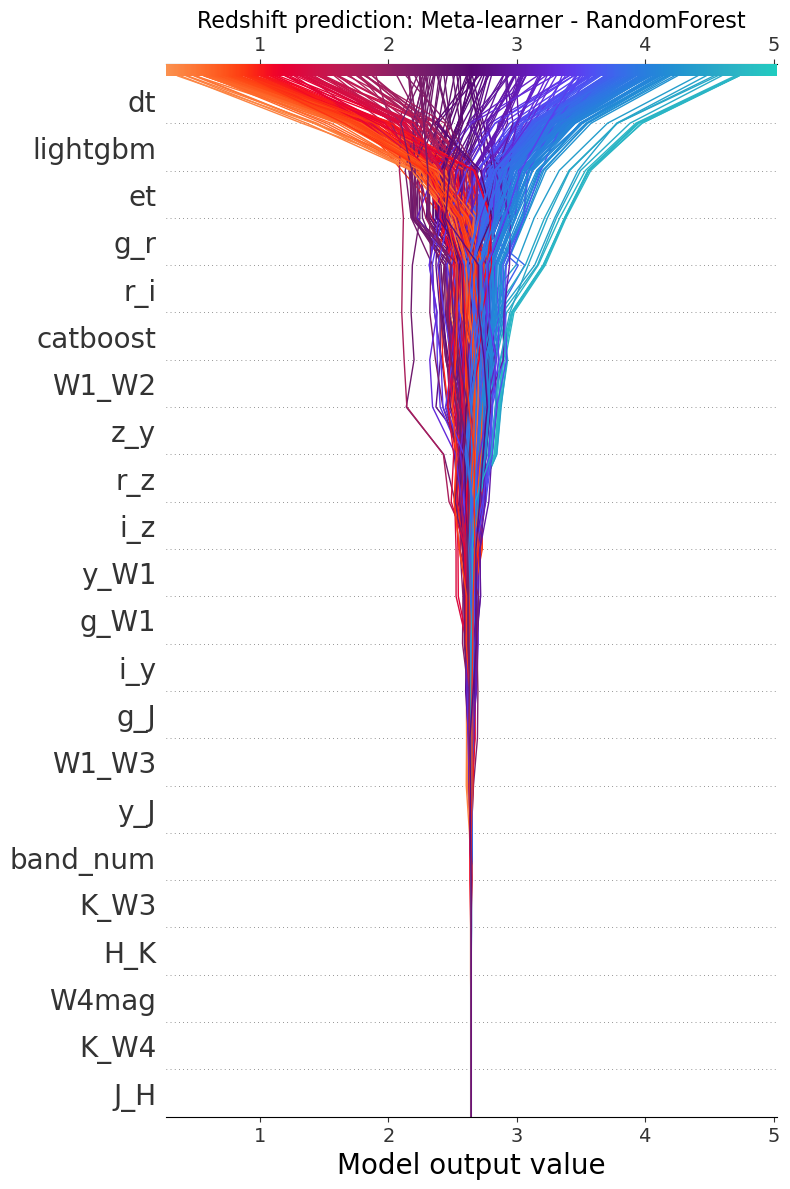

In [66]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_z_meta:
    xlims_plt       = (full_catalog_df.loc[reduced_idx_z, 'Score_radio'].min(),\
                       full_catalog_df.loc[reduced_idx_z, 'Score_radio'].max())
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    shap.plots.decision(base_value=explainer_z_meta.expected_value,
                        shap_values=shap_values_z_meta.values,
                        feature_names=reduced_cols_z.to_list(),
                        link='identity', plot_color=selected_color,
                        highlight=None, auto_size_plot=False,
                        show=False, xlim=None,
                        feature_display_range=slice(-1, -(len(shap_values_z_meta.feature_names) +1), -1))
    
    ax1.tick_params('x', labelsize=14)
    ax1.xaxis.get_offset_text().set_fontsize(14)
    #ax1.xaxis.get_offset_text().set_position((0,1))
    ax1.tick_params('y', labelsize=20)
    # plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax1.xaxis.label.set_size(20)
    
    plt.title(f'Redshift prediction: Meta-learner - {model_name_z}', fontsize=16)
    
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_decision_z_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

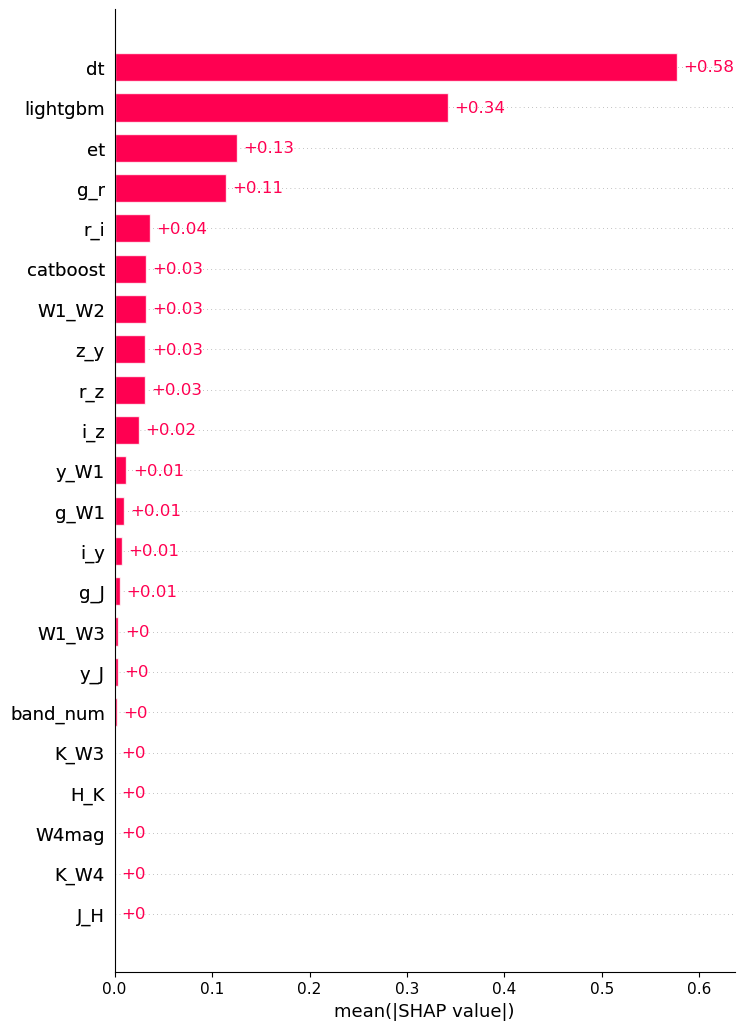

In [67]:
if run_shap_z_meta:
    shp_copy_z = shap.Explanation(values=shap_values_z_meta.values,\
                                    base_values=shap_values_z_meta.base_values,\
                                    data=shap_values_z_meta.data,\
                                    feature_names=shap_values_z_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_z, max_display=len(shp_copy_z.feature_names), show=False)
    plt.show()

In [68]:
if run_shap_z_meta:
    # The model's raw prediction for the first observation.
    print(redshift_reg.named_steps['trained_model'].final_estimator_.predict(reduced_data_z_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_z_meta.expected_value + shap_values_z_meta.values[0].sum()).round(5))

2.78034
2.78041


---

#### SHAP - Second redshift prediction model

In [69]:
if run_shap_high_z_meta & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [70]:
if run_shap_high_z_meta & use_second_z_model:
    sample_size_high_z      = 1000
    filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                np.array(full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol))
    sample_size_high_z      = np.nanmin([sample_size_high_z, np.sum(filter_selection)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

In [71]:
if run_shap_high_z_meta & use_second_z_model:
    estimators_list_high_z = get_base_estimators_names(redshift_reg_2)

In [72]:
if run_shap_high_z_meta & use_second_z_model:
    reduced_data_high_z = full_catalog_df.loc[:,\
                                         get_final_column_names(redshift_reg_2, full_catalog_df)].sample(n=sample_size_high_z, random_state=seed).copy()
    reduced_idx_high_z  = reduced_data_high_z.index
    reduced_cols_high_z = reduced_data_high_z.columns
    reduced_cols_high_z = reduced_data_high_z.columns.insert(0, estimators_list_high_z[0])
    if len(estimators_list_high_z) > 1:
        for est_name in estimators_list_high_z[1::]:
            reduced_cols_high_z = reduced_cols_high_z.insert(0, est_name)

In [73]:
if run_shap_high_z_meta & use_second_z_model:
    print('Running data pre-processing:\n')
    if isinstance(redshift_reg_2, sklearn.pipeline.Pipeline):
        prep_steps = redshift_reg_2.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_high_z = method.transform(reduced_data_high_z)
    reduced_data_high_z_df = pd.DataFrame(reduced_data_high_z, columns=reduced_cols_high_z, index=reduced_idx_high_z)

Use FastTreeSHAP package

In [74]:
if run_shap_high_z_meta & use_second_z_model:
    explainer_high_z_meta = fasttreeshap.TreeExplainer(redshift_reg_2.named_steps['trained_model'].final_estimator_,\
                                                       feature_perturbation='tree_path_dependent',\
                                                       model_output='raw', feature_dependence='independent',\
                                                       algorithm='auto', n_jobs=12)

In [75]:
if run_shap_high_z_meta & use_second_z_model:
    print('Working with meta-model')
    shap_values_high_z_meta = explainer_high_z_meta(reduced_data_high_z_df)

In [76]:
if run_shap_high_z_meta & use_second_z_model:
    explainer_high_z_meta.expected_value

In [77]:
if run_shap_high_z_meta & use_second_z_model:
    shap.plots.beeswarm(copy.deepcopy(shap_values_high_z_meta), log_scale=False, show=False, color_bar=False,
                        color=selected_color, max_display=len(shap_values_high_z_meta.feature_names), alpha=1.0)
    _, h = plt.gcf().get_size_inches()

    m = cm.ScalarMappable(cmap=selected_color)
    cb = plt.colorbar(m, ticks=[0, 1], aspect=100)
    cb.set_ticklabels([shap.plots._labels.labels['FEATURE_VALUE_LOW'], shap.plots._labels.labels['FEATURE_VALUE_HIGH']])
    cb.set_label(shap.plots._labels.labels["FEATURE_VALUE"], size=16, labelpad=-20)
    cb.ax.tick_params(labelsize=16, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

    plt.gca().tick_params('x', labelsize=14)
    plt.gca().xaxis.get_offset_text().set_fontsize(14)
    plt.gca().xaxis.get_offset_text().set_position((0,1))
    plt.gca().tick_params('y', labelsize=20)
    plt.gca().xaxis.label.set_size(20)

    plt.title(f'High redshift prediction: Meta-learner - {model_name_high_z}', fontsize=16)

    plt.gcf().set_size_inches(h, h*3/2)
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_high_z_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

In [78]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_high_z_meta & use_second_z_model:
    xlims_plt       = (full_catalog_df.loc[reduced_idx_high_z, 'Score_radio'].min(),\
                       full_catalog_df.loc[reduced_idx_high_z, 'Score_radio'].max())
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    shap.plots.decision(base_value=explainer_high_z_meta.expected_value,
                        shap_values=shap_values_high_z_meta.values,
                        feature_names=reduced_cols_high_z.to_list(),
                        link='identity', plot_color=selected_color,
                        highlight=None, auto_size_plot=False,
                        show=False, xlim=None,
                        feature_display_range=slice(-1, -(len(shap_values_high_z_meta.feature_names) +1), -1))
    
    ax1.tick_params('x', labelsize=14)
    ax1.xaxis.get_offset_text().set_fontsize(14)
    #ax1.xaxis.get_offset_text().set_position((0,1))
    ax1.tick_params('y', labelsize=20)
    # plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax1.xaxis.label.set_size(20)
    
    plt.title(f'High redshift prediction: Meta-learner - {model_name_high_z}', fontsize=16)
    
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/SHAP_decision_high_z_meta_learner_{used_area}.pdf', bbox_inches='tight')
    plt.show()

In [79]:
if run_shap_high_z_meta & use_second_z_model:
    shp_copy_high_z = shap.Explanation(values=shap_values_high_z_meta.values,\
                                    base_values=shap_values_high_z_meta.base_values,\
                                    data=shap_values_high_z_meta.data,\
                                    feature_names=shap_values_high_z_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_high_z, max_display=len(shp_copy_high_z.feature_names), show=False)
    plt.show()

In [80]:
if run_shap_high_z_meta & use_second_z_model:
    # The model's raw prediction for the first observation.
    print(redshift_reg_2.named_steps['trained_model'].final_estimator_.predict(reduced_data_high_z_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_high_z_meta.expected_value + shap_values_high_z_meta.values[0].sum()).round(5))